In [1]:
from google.colab import drive
drive.mount( '/gdrive')


Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


In [2]:
import pandas as pd
import xgboost as xgb
import numpy as np
from sklearn import preprocessing
from xgboost import plot_importance
import matplotlib.pyplot as plt


In [3]:
wasterWaterURL = "/gdrive/My Drive/MLcontent/Wastewater_Data.csv"
wasteDF = pd.read_csv(wasterWaterURL, header=0, parse_dates=[0], index_col=0, squeeze=True)
wasteDF = wasteDF.replace('^\s*$', np.nan, regex=True)
wasteDF = wasteDF.fillna(method='ffill')
wasteDF = wasteDF.apply(pd.to_numeric)

In [4]:
def table2lags(table, max_lag, min_lag=1, separator='_'):
    values = []
    for i in range(min_lag, max_lag + 1):
        #append shiffted dataframe into the list (i.e., values)
        values.append(table.shift(i).copy()) 
        #replace the last item or dataframe's columns by column_n; n is the shift step  
        values[-1].columns = [c + separator + str(i) for c in table.columns] 
    #pandas.concat is used to merge all dataframes (as items in values) into a single dataframe
    return pd.concat(values, axis=1)

In [5]:
#names = wasteDF.columns
#wasteArray = wasteDF.values #returns a numpy array
#min_max_scaler = preprocessing.MinMaxScaler()
#wasteArray_scaled = min_max_scaler.fit_transform(wasteArray)
#waste_normalized = pd.DataFrame(wasteArray_scaled, columns=names)

In [6]:
lag = 7
#extend input
shiftDF = table2lags(wasteDF, lag)
shiftDF = shiftDF.fillna(method='bfill')
shiftDF

,Total Solids_1,SS_1,BOD5_1,NH3_1,Org-N_1,P-TOT_1,SO4_1,TKN_1,PRCP_NOOA_1,Total Solids_2,SS_2,BOD5_2,NH3_2,Org-N_2,P-TOT_2,SO4_2,TKN_2,PRCP_NOOA_2,Total Solids_3,SS_3,BOD5_3,NH3_3,Org-N_3,P-TOT_3,SO4_3,TKN_3,PRCP_NOOA_3,Total Solids_4,SS_4,BOD5_4,NH3_4,Org-N_4,P-TOT_4,SO4_4,TKN_4,PRCP_NOOA_4,Total Solids_5,SS_5,BOD5_5,NH3_5,Org-N_5,P-TOT_5,SO4_5,TKN_5,PRCP_NOOA_5,Total Solids_6,SS_6,BOD5_6,NH3_6,Org-N_6,P-TOT_6,SO4_6,TKN_6,PRCP_NOOA_6,Total Solids_7,SS_7,BOD5_7,NH3_7,Org-N_7,P-TOT_7,SO4_7,TKN_7,PRCP_NOOA_7
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2001-01-01,984.0,170.0,173.0,15.93,14.0,4.58,72.0,29.97,0.00,984.0,170.0,173.0,15.93,14.0,4.58,72.0,29.97,0.00,984.0,170.0,173.0,15.93,14.0,4.58,72.0,29.97,0.00,984.0,170.0,173.0,15.93,14.0,4.58,72.0,29.97,0.00,984.0,170.0,173.0,15.93,14.0,4.58,72.0,29.97,0.0,984.0,170.0,173.0,15.93,14.0,4.58,72.0,29.97,0.00,984.0,170.0,173.0,15.93,14.0,4.58,72.0,29.97,0.00
2001-01-02,984.0,170.0,173.0,15.93,14.0,4.58,72.0,29.97,0.00,984.0,170.0,173.0,15.93,14.0,4.58,72.0,29.97,0.00,984.0,170.0,173.0,15.93,14.0,4.58,72.0,29.97,0.00,984.0,170.0,173.0,15.93,14.0,4.58,72.0,29.97,0.00,984.0,170.0,173.0,15.93,14.0,4.58,72.0,29.97,0.0,984.0,170.0,173.0,15.93,14.0,4.58,72.0,29.97,0.00,984.0,170.0,173.0,15.93,14.0,4.58,72.0,29.97,0.00
2001-01-03,924.0,122.0,174.0,15.52,14.4,4.52,72.0,29.96,0.00,984.0,170.0,173.0,15.93,14.0,4.58,72.0,29.97,0.00,984.0,170.0,173.0,15.93,14.0,4.58,72.0,29.97,0.00,984.0,170.0,173.0,15.93,14.0,4.58,72.0,29.97,0.00,984.0,170.0,173.0,15.93,14.0,4.58,72.0,29.97,0.0,984.0,170.0,173.0,15.93,14.0,4.58,72.0,29.97,0.00,984.0,170.0,173.0,15.93,14.0,4.58,72.0,29.97,0.00
2001-01-04,1135.0,300.0,303.0,14.19,21.9,6.06,72.0,36.11,0.00,924.0,122.0,174.0,15.52,14.4,4.52,72.0,29.96,0.00,984.0,170.0,173.0,15.93,14.0,4.58,72.0,29.97,0.00,984.0,170.0,173.0,15.93,14.0,4.58,72.0,29.97,0.00,984.0,170.0,173.0,15.93,14.0,4.58,72.0,29.97,0.0,984.0,170.0,173.0,15.93,14.0,4.58,72.0,29.97,0.00,984.0,170.0,173.0,15.93,14.0,4.58,72.0,29.97,0.00
2001-01-05,1013.0,192.0,228.0,15.43,19.4,5.33,72.0,34.83,0.00,1135.0,300.0,303.0,14.19,21.9,6.06,72.0,36.11,0.00,924.0,122.0,174.0,15.52,14.4,4.52,72.0,29.96,0.00,984.0,170.0,173.0,15.93,14.0,4.58,72.0,29.97,0.00,984.0,170.0,173.0,15.93,14.0,4.58,72.0,29.97,0.0,984.0,170.0,173.0,15.93,14.0,4.58,72.0,29.97,0.00,984.0,170.0,173.0,15.93,14.0,4.58,72.0,29.97,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-12-27,1052.0,294.0,197.0,18.96,16.8,5.65,85.0,35.74,0.00,922.0,192.0,176.0,19.07,11.0,4.35,85.0,30.09,0.00,888.0,150.0,151.0,17.28,10.8,3.91,99.0,28.03,0.00,844.0,128.0,126.0,17.19,8.9,3.23,99.0,26.04,0.00,894.0,142.0,134.0,16.18,9.9,3.87,99.0,26.06,0.0,920.0,136.0,121.0,14.42,10.0,3.60,99.0,24.42,0.05,1026.0,166.0,187.0,17.40,9.0,4.44,99.0,26.38,0.10
2018-12-28,892.0,264.0,157.0,12.45,11.1,3.84,85.0,23.53,0.66,1052.0,294.0,197.0,18.96,16.8,5.65,85.0,35.74,0.00,922.0,192.0,176.0,19.07,11.0,4.35,85.0,30.09,0.00,888.0,150.0,151.0,17.28,10.8,3.91,99.0,28.03,0.00,844.0,128.0,126.0,17.19,8.9,3.23,99.0,26.04,0.0,894.0,142.0,134.0,16.18,9.9,3.87,99.0,26.06,0.00,920.0,136.0,121.0,14.42,10.0,3.60,99.0,24.42,0.05
2018-12-29,776.0,104.0,94.0,10.61,6.2,1.97,85.0,16.76,0.08,892.0,264.0,157.0,12.45,11.1,3.84,85.0,23.53,0.66,1052.0,294.0,197.0,18.96,16.8,5.65,85.0,35.74,0.00,922.0,192.0,176.0,19.07,11.0,4.35,85.0,30.09,0.00,888.0,150.0,151.0,17.28,10.8,3.91,99.0,28.03,0.0,844.0,128.0,126.0,17.19,8.9,3.23,99.0,26.04,0.00,894.0,142.0,134.0,16.18,9.9,3.87,99.0,26.06,0.00


In [7]:
def extendList(inputList, lag, separator='_'):
    ret = []
    for s in inputList:
        for i in range(1, lag+1):
            ret.append(s + separator + str(i))
    return ret

In [8]:
#choice input
needFeatures = ['Total Solids']
needFeaturesShift = extendList(needFeatures, 7)
shiftDF = shiftDF[needFeaturesShift]


In [10]:
targetname = 'Total Solids'
targetDF = wasteDF[targetname].to_frame()
type(targetDF)

pandas.core.frame.DataFrame

In [13]:
TVsize = int(len(wasteDF) * 0.6)
VTsize = int(len(wasteDF) * 0.8)

train_data = shiftDF[0:TVsize]
train_target = targetDF[0:TVsize]

val_data = shiftDF[TVsize:VTsize]
val_target = targetDF[TVsize:VTsize]

test_data = shiftDF[VTsize:]
test_target = targetDF[VTsize:]

In [14]:
from sklearn.ensemble import RandomForestRegressor

In [15]:
train_target.values.ravel()

array([ 984.,  924., 1135., ...,  854.,  892.,  846.])

In [16]:
rnd_reg = RandomForestRegressor()
rnd_reg.fit(train_data, train_target.values.ravel())

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [19]:
presult = rnd_reg.predict(test_data)

In [20]:
presult

array([ 934.35,  934.64, 1037.83, ...,  887.66,  877.51,  905.29])

In [21]:
test_target.values

array([[ 868.],
       [1063.],
       [1012.],
       ...,
       [ 898.],
       [ 878.],
       [ 920.]])

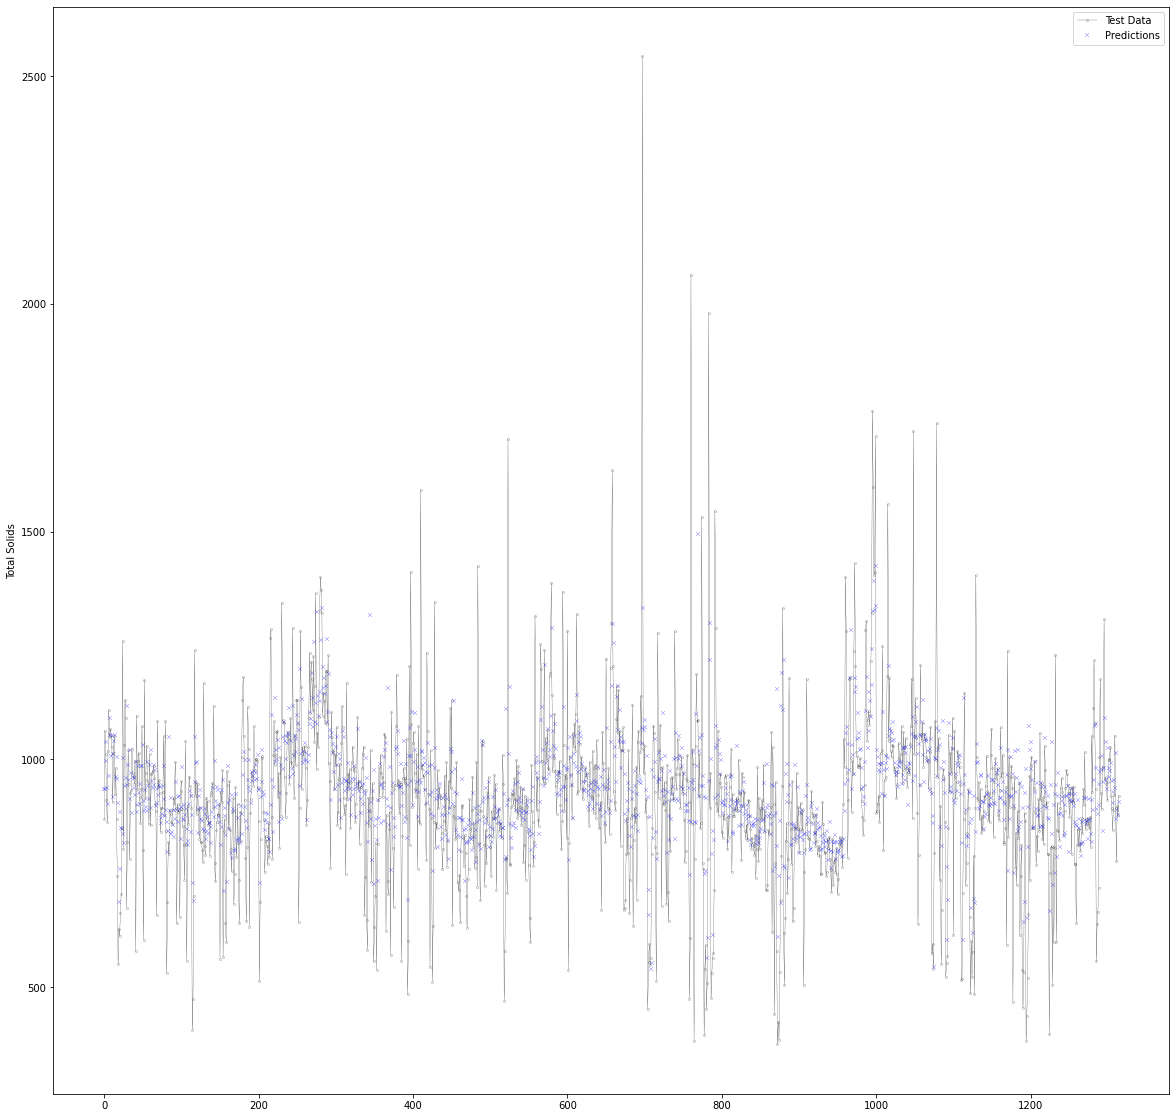

In [28]:
plt.figure(figsize=(20, 20))
plt.plot(test_target.values, color='black', linewidth=.2, marker='o', markersize=2,
                markeredgecolor='black', markeredgewidth=0.2, fillstyle='none')
plt.plot(presult, color='blue', linewidth=4, linestyle=' ', marker='x', markersize=4,
                markeredgecolor='blue', markeredgewidth=.2, fillstyle='none')
plt.legend(('Test Data', 'Predictions'))
plt.ylabel(targetname)

plt.show()

In [24]:
def mae(y_true, y_pred):
  mae = np.mean(np.abs(y_true - y_pred))
  print("mae" + str(mae))


In [25]:
mae(test_target.values, presult)

mae156.45932416627588
